# Boys and girls

+ 1 Introduction 介绍
+ 2 Load and check data 加载并检查数据
    + 2.1 load data 加载数据
    + 2.2 Outlier detection 异常值检测
    + 2.3 joining train and test set 拼接训练集和测试集
    + 2.4 check for null and missing values 检查缺失值
+ 3 Feature analysis 特征分析
    + 3.1 Numerical values 数值特征
    + 3.2 Categorical values 类别特征
+ 4 Filling missing Values 填补缺失数据
    + 4.1 Age 年龄
+ 5 Feature engineering 特征工程
    + 5.1 Name/Title 名字/职称
    + 5.2 Family Size 家庭大小
    + 5.3 Cabin 船舱
    + 5.4 Ticket 票
+ 6 Modeling 建模
    + 6.1 Simple modeling 简单模型
        + 6.1.1 Cross validate models 交叉验证模型
        + 6.1.2 Hyperparamater tunning for best models 微调超参数
        + 6.1.3 Plot learning curves 绘制学习曲线
        + 6.1.4 Feature importance of the tree based classifiers 特征重要性
    + 6.2 Ensemble modeling 模型融合
        + 6.2.1 Combining models 融合模型
    + 6.3 Prediction 预测
        + 6.3.1 Predict and Submit results 预测并提交结果
        
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

https://www.kaggle.com/headsortails/pytanic

## 1. 介绍
男孩还是女孩是一个二分类问题，类别均衡，比赛地址为https://www.kaggle.com/c/girls-and-boys

## 2. 加载并检查数据
### 2.1 加载数据

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv',header=None)
test = pd.read_csv('test.csv',header=None)
target = train[249]
#248列是迷惑特征，有数据泄露
train = train.drop([248],axis=1)
test = test.drop([248],axis=1)

In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,249
0,1.280000e+11,983.0,1080.0,1190.0,1200.0,586.18422,849.72675,1006.80617,1174.74439,1174.74439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DP0-L-3,36,-1
1,1.280000e+11,826.0,1060.0,1160.0,1120.0,400.33860,825.47838,1048.93397,1079.99396,1079.99396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IW9-I-3,56,1
2,1.280000e+11,1040.0,1170.0,1250.0,1180.0,125.85468,385.36105,947.27780,1182.54942,1182.54942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AP0-I-3,56,1
3,1.280000e+11,1100.0,1140.0,1240.0,1180.0,825.63722,881.96425,1086.06402,1186.67985,1186.67985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AN0-L-2,37,1
4,1.280000e+11,910.0,1150.0,1250.0,1220.0,551.03916,730.62394,984.53070,1200.22696,1200.22696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IR4-L-2,36,1


### 2.2 异常值检测

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   
 


In [5]:
def sort_categorical_feature(df):
    categorical_feature=[]
    numerical_feature=[]
    col_type = df.dtypes
   
    for k in list(col_type.index):
        if col_type[k]== np.object:
            categorical_feature.append(k)
        else:
            numerical_feature.append(k)
        
        
    return categorical_feature,numerical_feature
        


In [6]:
[categorical_feature,numerical_feature] = sort_categorical_feature(train)
numerical_feature
Outliers_to_drop = detect_outliers(train,10,numerical_feature)
#train.loc[Outliers_to_drop] # Show the outliers rows

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [7]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
target = train[249]

In [8]:
train.shape

(74707, 249)

In [9]:
target.shape

(74707,)

### 2.3 连接训练集和测试集

In [10]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
## 对训练数据和测试数据进行一致的特征处理
train_len = len(train)
dataset =  pd.concat(objs=[train.drop(249,axis=1), test], axis=0).reset_index(drop=True)

### 2.4 检测缺失值

In [11]:
missing_data = dataset.isnull().sum()
missing_data =missing_data[missing_data!=0]
missing_data.sort_values(ascending=False)[:20]
# plt.figure(figsize=(15,20))
# g = sns.barplot(y=list(missing_data.index),x=list(missing_data.values),orient='h')
# g.set_xlabel("Missing Data",fontsize=12)
# g.set_ylabel("Features",fontsize=12)
# g.tick_params(labelsize=9)
# g.set_title("Missing Data")

249    93933
73     93933
43     93933
44     93933
29     93933
74     93933
30     93933
72     93933
71     93933
70     93933
69     93933
64     92984
63     92984
66     92984
68     92984
42     92984
41     92984
65     92984
67     92984
137    43937
dtype: int64

In [12]:
train.info()
train.isnull().sum().sort_values(ascending=False)[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74707 entries, 0 to 74706
Columns: 249 entries, 0 to 249
dtypes: float64(173), int64(49), object(27)
memory usage: 141.9+ MB


74    74707
43    74707
73    74707
72    74707
71    74707
44    74707
70    74707
69    74707
29    74707
30    74707
dtype: int64

In [13]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,238,239,240,241,242,243,244,245,247,249
count,7.470700e+04,74634.000000,74707.000000,74618.000000,74614.000000,74707.000000,74707.000000,74696.000000,74697.000000,74697.000000,...,74693.000000,74693.0,74693.0,74693.0,74693.0,74693.0,74693.0,74693.0,74707.000000,74707.000000
mean,1.283081e+11,1070.068829,1103.325391,1184.055429,1183.007210,414.559725,645.765624,960.414721,1145.824279,1145.824279,...,0.000066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.240566,-0.066379
std,4.617155e+08,127.390698,52.789166,49.661377,38.032623,264.808588,164.100543,84.438072,32.182527,32.182527,...,0.000264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.902564,0.997801
min,1.280000e+11,605.000000,857.000000,847.000000,1030.000000,15.431800,43.789800,43.789800,43.789800,43.789800,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.000000,-1.000000
25%,1.280000e+11,1050.000000,1070.000000,1150.000000,1160.000000,160.442010,510.610635,899.120845,1126.795550,1126.795550,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.000000,-1.000000
50%,1.280000e+11,1120.000000,1110.000000,1190.000000,1190.000000,421.741840,652.668000,963.880365,1149.436280,1149.436280,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.000000,-1.000000
75%,1.290000e+11,1150.000000,1140.000000,1220.000000,1210.000000,636.430300,771.369810,1023.852370,1167.328030,1167.328030,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.000000,1.000000
max,1.290000e+11,1350.000000,1290.000000,1330.000000,1310.000000,1023.508080,1126.293640,1242.962680,1255.543427,1255.543427,...,0.002000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.000000,1.000000


## 3. 特征分析
### 3.1 数值型特征

#### 相关性

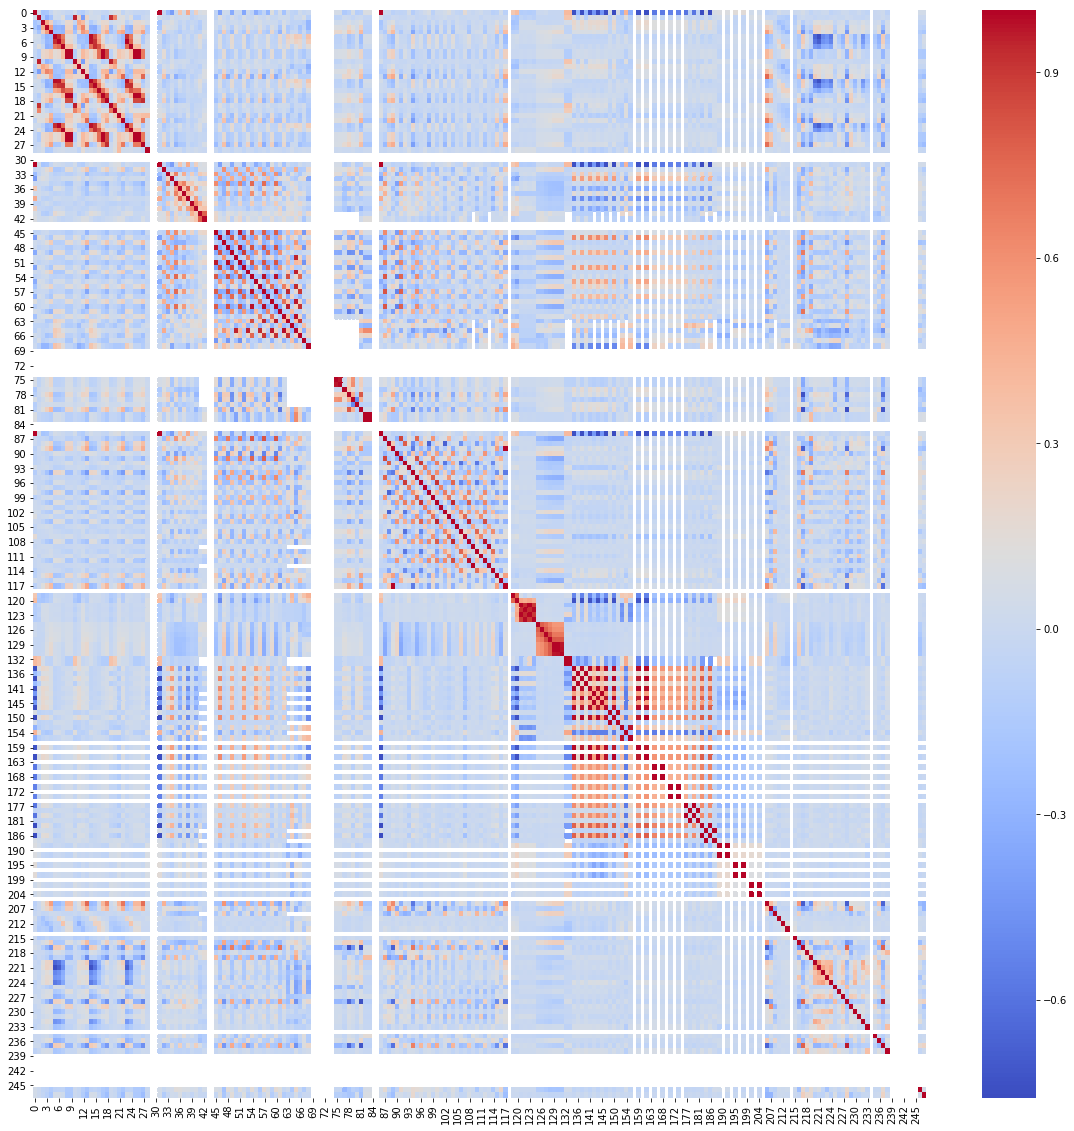

In [14]:
train_corr = train[numerical_feature].corr()
plt.figure(figsize=(20,20))
g = sns.heatmap(train_corr,annot=False, fmt = ".2f", cmap = "coolwarm")

In [15]:
most_corr = abs(train_corr[249]).sort_values(ascending=False)[:20]

In [16]:
boys = train[train[249]==1]
girls = train[train[249]==-1]
boys_col = "blue"
girls_col = "red"

#### 高相关特征的分布

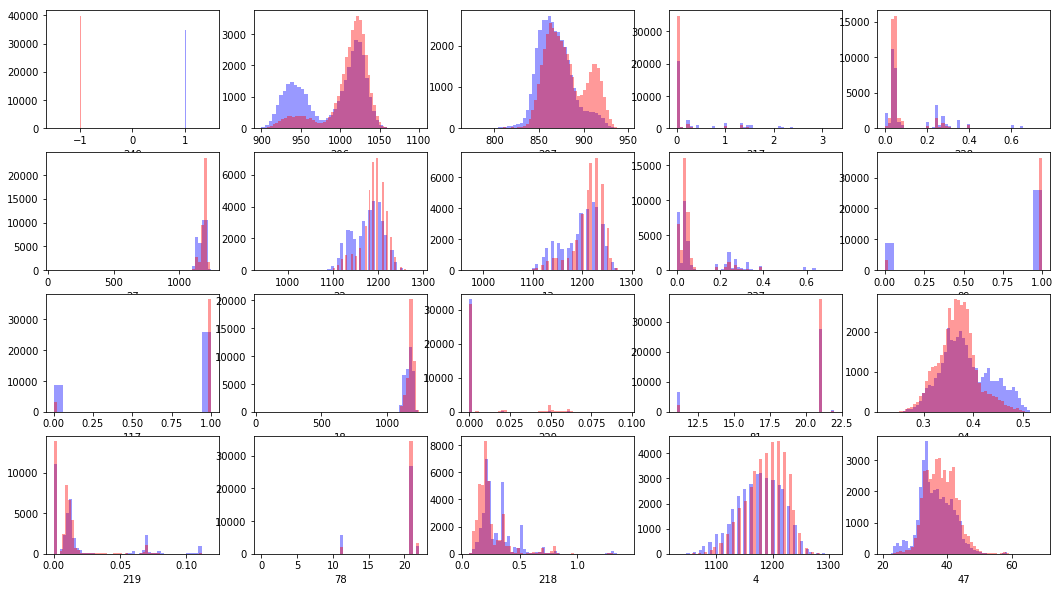

In [17]:

plt.figure(figsize=[18,10])
i=1
for k in list(most_corr.index):
    plt.subplot(4,5,i)
    sns.distplot(boys[k].dropna().values,  kde=False, color=boys_col)
    sns.distplot(girls[k].dropna().values,  kde=False, color=girls_col,
            axlabel=k)
    i+=1


#### 斜度/峰度

In [18]:
#斜度
dataskew = dataset.skew()

In [19]:
#峰度
datakurt = dataset.kurt()

## 4. 填补缺失值

In [20]:
all_nan_col = dataset[missing_data[(missing_data/dataset.shape[0])==1].index]
dataset =dataset.drop(all_nan_col.columns,axis=1)

In [21]:
missing_data_rate=(missing_data[missing_data!=93933]/dataset.shape[0]).sort_values(ascending=False)
missing_data_rate[:25]

64     0.989897
68     0.989897
63     0.989897
41     0.989897
42     0.989897
67     0.989897
66     0.989897
65     0.989897
132    0.467748
133    0.467748
134    0.467748
140    0.467748
143    0.467748
146    0.467748
152    0.467748
155    0.467748
158    0.467748
161    0.467748
137    0.467748
149    0.467748
139    0.048311
154    0.048311
120    0.048311
150    0.048311
148    0.048311
dtype: float64

In [22]:
train_corr[249][missing_data_rate[missing_data_rate>0.1].index]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


64    -0.070142
68    -0.006857
63    -0.071314
41    -0.021431
42    -0.022369
67    -0.005773
66    -0.058788
65     0.070528
132    0.001862
133    0.001862
134         NaN
140         NaN
143         NaN
146         NaN
152         NaN
155         NaN
158         NaN
161         NaN
137         NaN
149         NaN
Name: 249, dtype: float64

### 4.1数值型缺失值

#### 4.1.1 第66列缺失值

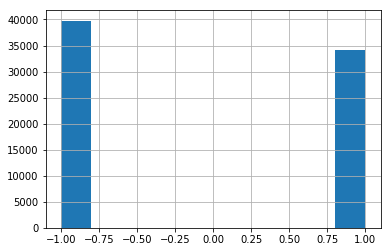

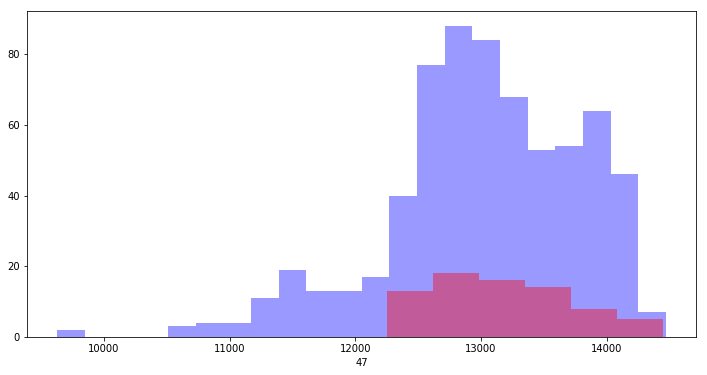

In [23]:
col_66 = train[66]
target[col_66[col_66.isnull()].index].hist()
plt.figure(figsize=[12,6])    
sns.distplot(boys[66].dropna().values,  kde=False, color=boys_col)
sns.distplot(girls[66].dropna().values,  kde=False, color=girls_col,
            axlabel=k)

In [24]:
train_corr[66].sort_values(ascending=False)[:5]

66    1.000000
63    0.923743
60    0.923524
57    0.900378
54    0.756482
Name: 66, dtype: float64

In [25]:
train_corr[249][63]

-0.07131421430709949

可见60与66列相关度很强，且没有太多缺失值

#### 4.1.2 65列缺失值分析

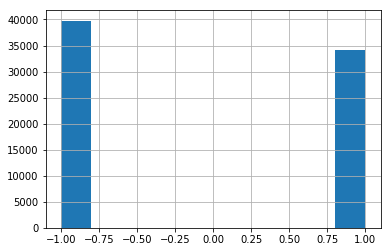

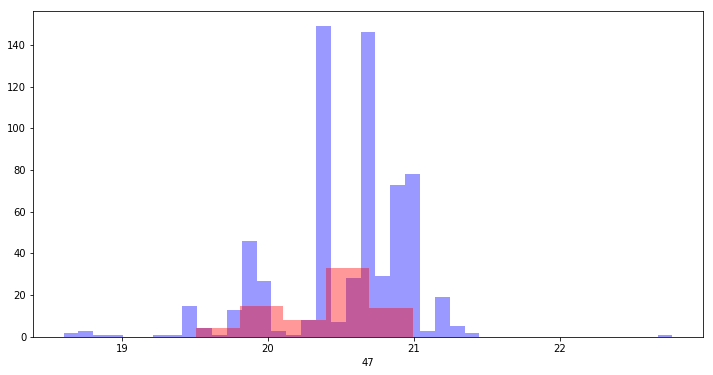

In [26]:
col_65 = train[65]
target[col_65[col_65.isnull()].index].hist()
plt.figure(figsize=[12,6])    
sns.distplot(boys[65].dropna().values,  kde=False, color=boys_col)
sns.distplot(girls[65].dropna().values,  kde=False, color=girls_col,
            axlabel=k)

In [27]:
train_corr[65].sort_values(ascending=False)[:5]

65    1.000000
62    0.984988
59    0.970343
53    0.955073
50    0.945239
Name: 65, dtype: float64

In [28]:
train_corr[249][62]

-0.127015748310128

65列与62列相关性极强，且62与结果相关性很强

#### 4.1.3 63,64列缺失值分析

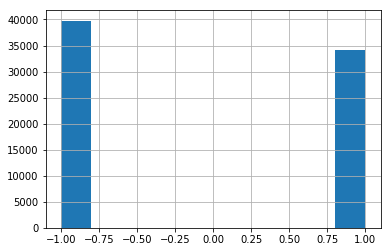

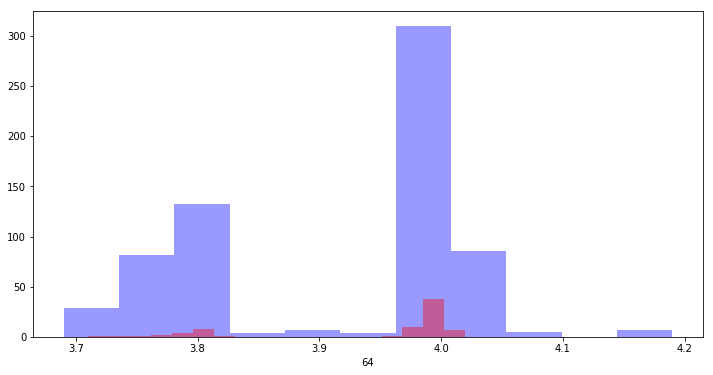

In [29]:
col_64 = train[64]
target[col_64[col_64.isnull()].index].hist()
plt.figure(figsize=[12,6])    
sns.distplot(boys[64].dropna().values,  kde=False, color=boys_col)
sns.distplot(girls[64].dropna().values,  kde=False, color=girls_col,
            axlabel=64)

In [30]:
train_corr[64].sort_values(ascending=False)[:5]

64     1.000000
119    0.420292
180    0.410123
177    0.405444
61     0.396951
Name: 64, dtype: float64

In [31]:
train_corr[249][119]

-0.001653156663461549

**待删除数值特征**

41 42 63 64 66 67 68 132 133 

### 4.2类别型特征

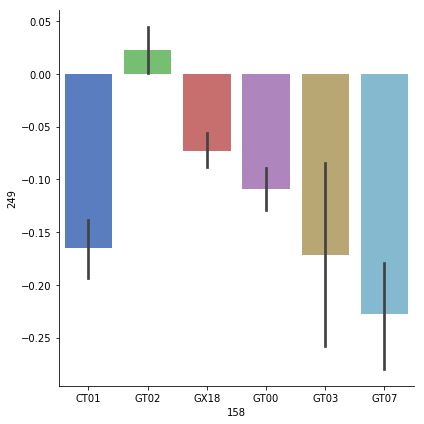

In [32]:
#可以考虑转化为若干类，缺失值的单独为一类
g = sns.factorplot(x=158,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

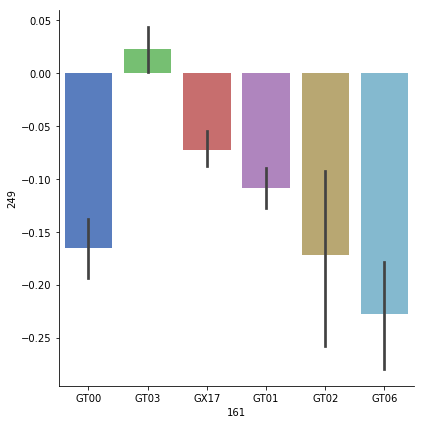

In [33]:
g = sns.factorplot(x=161,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

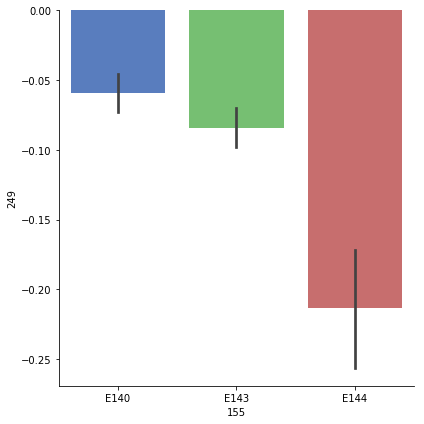

In [34]:
g = sns.factorplot(x=155,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

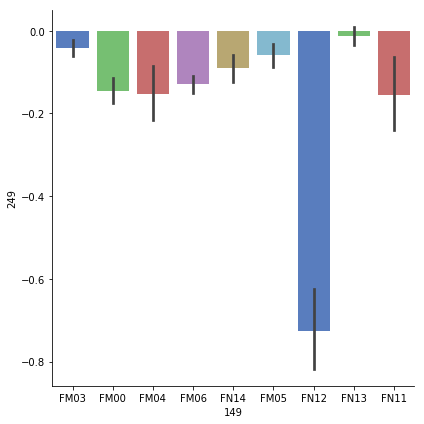

In [35]:
g = sns.factorplot(x=149,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

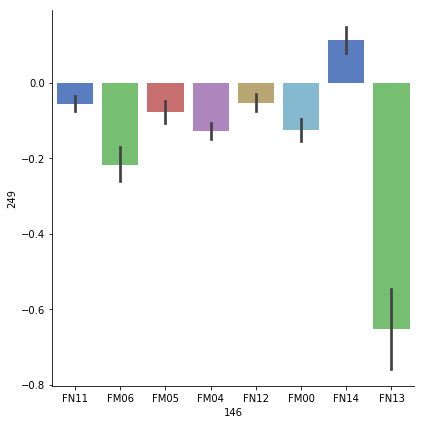

In [36]:
g = sns.factorplot(x=146,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

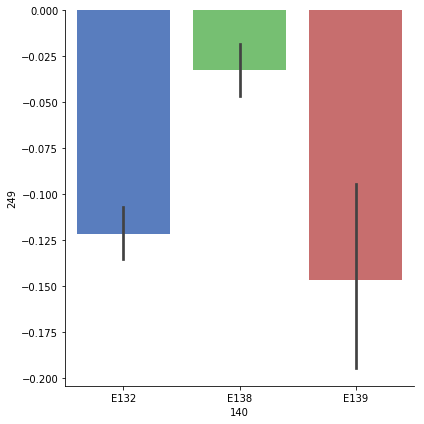

In [37]:
g = sns.factorplot(x=140,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

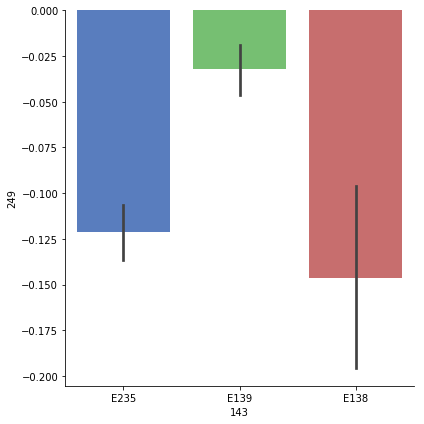

In [38]:
g = sns.factorplot(x=143,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

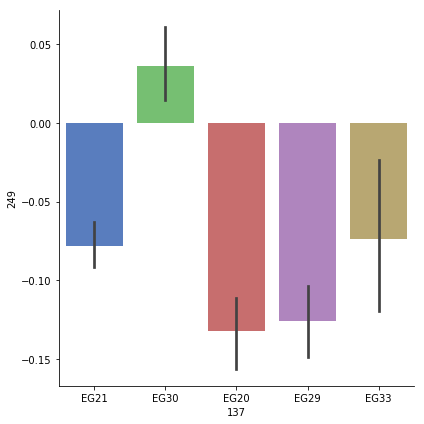

In [39]:
g = sns.factorplot(x=137,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

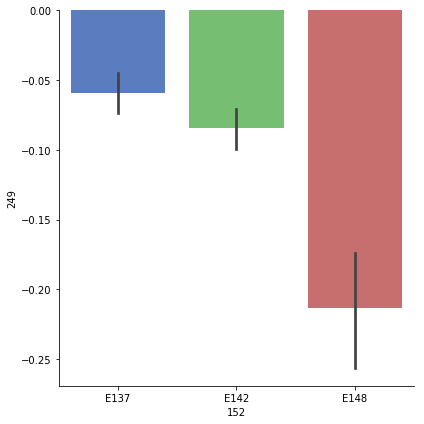

In [40]:
g = sns.factorplot(x=152,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

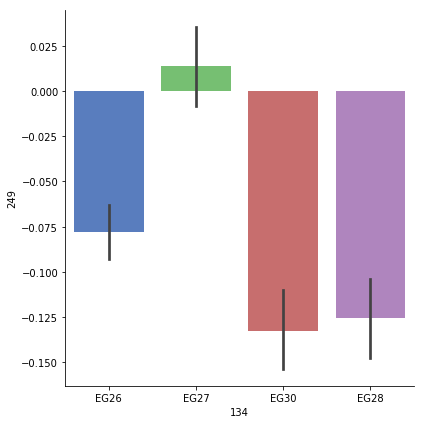

In [41]:
g = sns.factorplot(x=134,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

**待删除类别列**

161，143,152

#### 删除缺失值列

In [42]:
dataset = dataset.drop([161,143,152,41, 42, 63, 64,65, 66, 67, 68, 132, 133,200,208,209,170,197,140,
                       105,109,113,122,124,184,187,213,215,235,230],axis=1)

#### 填补缺失值列

In [43]:
dataset=dataset.fillna({155:'none',134:'none',149:'none',137:'none',158:'none',146:'none',140:'none'})

In [44]:
nan_col = dataset.isnull().sum()

In [45]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values ='NaN',strategy='mean',verbose=0)
#imp.fit_transform(dataset)
[categorical_dataset,numerical_dataset] = sort_categorical_feature(dataset)

In [46]:
mean_dataset = dataset[numerical_dataset].mean()
dataset = dataset.fillna(mean_dataset.to_dict())

In [47]:
categorical_dataset

[134,
 137,
 146,
 149,
 155,
 158,
 164,
 167,
 173,
 176,
 179,
 182,
 185,
 188,
 191,
 194,
 203,
 246]

In [48]:
dataset[246]= dataset[246].str.slice(0,3)


## 5.特征工程

### 5.1 类别变量

['EG26' 'EG27' 'EG28' 'EG30' 'none'] 5
['EG20' 'EG21' 'EG29' 'EG30' 'EG33' 'none'] 6
['FM00' 'FM04' 'FM05' 'FM06' 'FN11' 'FN12' 'FN13' 'FN14' 'none'] 9
['FM00' 'FM03' 'FM04' 'FM05' 'FM06' 'FN11' 'FN12' 'FN13' 'FN14' 'none'] 10
['E140' 'E143' 'E144' 'none'] 4
['CT01' 'GT00' 'GT02' 'GT03' 'GT07' 'GX18' 'none'] 7
['HE00' 'HH58' 'HM03' 'HM05' 'HM54' 'HN54' 'HN56' 'HN58' 'HU133' 'HX01'
 'hn54'] 11
['HE01' 'HM04' 'HM06' 'HM55' 'HN55' 'HN57' 'HN59' 'HU09' 'HU134' 'HX02'
 'hn55'] 11
['IJ99' 'IMA6' 'IMA8' 'IMB1' 'IU83' 'IU85' 'IX01'] 7
['IH70' 'IHA84' 'IJ81' 'IJ86' 'IJ90' 'IJ92' 'IMA1' 'IMA3' 'IN54' 'IN56'
 'IU80'] 11
['IHA85' 'IJ78' 'IJ83' 'IJ87' 'IJ88' 'IJ93' 'IMA2' 'IMA4' 'IN55' 'IN57'
 'IU81'] 11
['JJD2' 'JJD4' 'JMD1' 'JMD3' 'JMD5' 'JMD7' 'JMD8' 'JQ06' 'JX976' 'JXB9'] 10
['JJD3' 'JJD5' 'JMB4' 'JMC9' 'JMD2' 'JMD4' 'JMD6' 'JMD9' 'JQ07' 'JX977'] 10
['ZQ13' 'ZQ18' 'ZQ22' 'ZX001' 'ZX003' 'ZX004' 'ZX005' 'ZX009' 'ZX011'
 'ZX013' 'ZX015' 'ZX017' 'ZX019' 'ZX022' 'ZX029' 'ZX031' 'ZX034' 'ZX041'
 'ZX

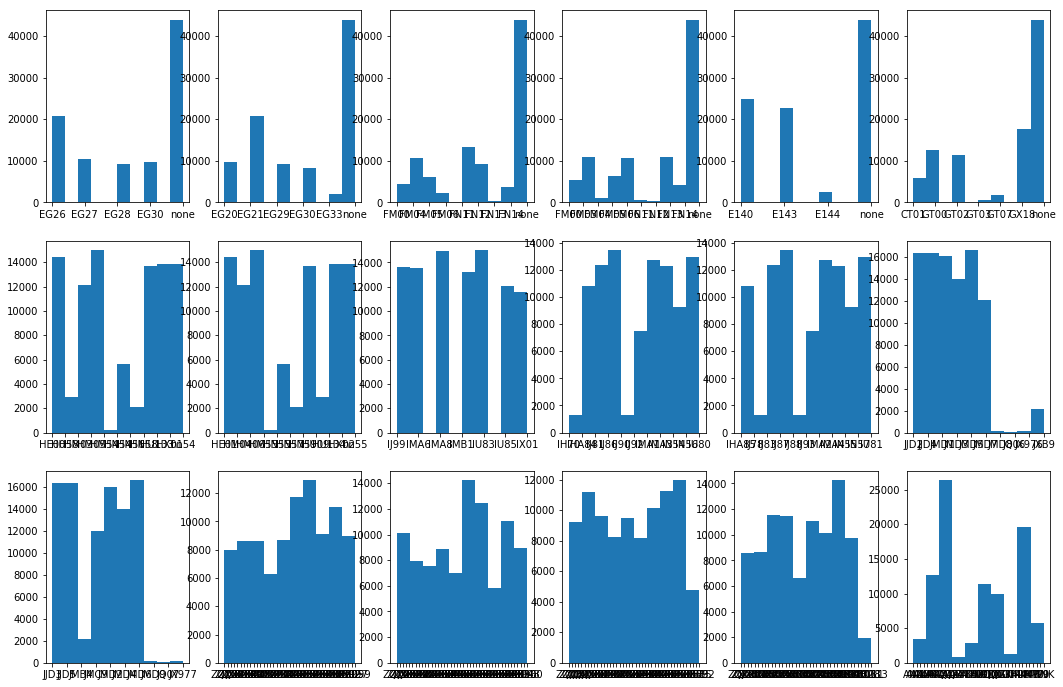

In [49]:
#170,197,140
plt.figure(figsize=[18,12])
i = 1
for k in categorical_dataset:
    plt.subplot(3,6,i)
    print(np.unique(dataset[k]),len(np.unique(dataset[k]))) 
    dataset[k].hist(grid=False)
    i+=1

In [50]:
dummy_cat_data = pd.get_dummies(dataset[categorical_dataset])
dataset = dataset.drop(categorical_dataset,axis=1)

### 5.2 数值变量

In [51]:
zeros_col = (dataset==0).sum().sort_values(ascending=False)
dataset =dataset.drop(zeros_col[zeros_col>90000].index,axis=1)

In [52]:
after_cat_col,after_num_col = sort_categorical_feature(dataset)

In [53]:
udup = dataset[:500].T.drop_duplicates().T
dataset = dataset[udup.columns]

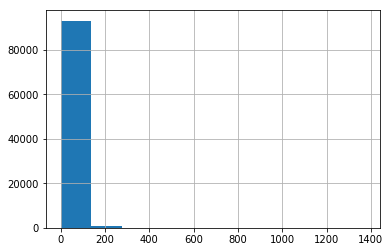

In [54]:
dataset[211].hist()

In [55]:
dataskew = abs(dataset.skew()).sort_values(ascending=False)

In [56]:
from scipy.stats import *
skewness_col = list(dataskew[dataskew.sort_values(ascending=False)>5].index)
plt.figure(figsize=[18,30])
i=1
for k in skewness_col:
    #plt.subplot(6,4,i)
    #g = dataset[k].hist(label='1')    
    print(k,train_corr[249][k],dataskew[k])
    #sns.distplot(dataset[k],axlabel=k,fit=norm,kde_kws={"label":dataskew[k]})
    i+=1


211 0.015477270387906776 14.992858031322939
212 0.014575501469914036 14.34245185267988
225 0.08918722191243841 10.891232946034458
75 -0.09959762072497474 10.0746712316108
148 0.021806370456765554 8.575818173305436
27 -0.24019000762340414 8.37134647495399
76 -0.10004648529767543 8.323775912600496
18 -0.22394340545264968 8.287533558151013
227 -0.0632921404814627 5.9827292001002546
233 -0.012163629683301824 5.911374205665324
226 -0.09134389205021143 5.845016363621594
123 -0.016442218592052173 5.694123156098916
121 -0.016579054074995277 5.688494557439819
17 -0.15941884018583471 5.657420247411164
25 -0.15947749395112823 5.656837120164164
8 -0.1595434881325276 5.651720404646831
80 0.05513614906852706 5.462605020268003
79 -0.1553369236691625 5.382697656622861


In [57]:
dataset.shape

(93933, 158)

In [58]:
from sklearn.preprocessing import RobustScaler
Rbs = RobustScaler()
dataset =pd.DataFrame(Rbs.fit_transform(dataset))

In [74]:
dataset = pd.concat([dataset,dummy_cat_data],axis=1)

In [75]:
dataset.shape

(93933, 472)

In [76]:
target.shape

(74707,)

## 6.建模

In [77]:
train_set = dataset[:train_len]
test_set = dataset[train_len:]

In [78]:
Y_train = target
X_train = train_set

#### 6.1.1 基模型

+ 决策树
+ AdaBoost
+ RandomForest
+ Extra Trees
+ 梯度提升树
+ 逻辑回归

In [79]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [80]:
# Cross validate model with Kfold stratified cross val
#StratifiedKFold用法类似Kfold，但是他是分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同
kfold = StratifiedKFold(n_splits=5)

In [81]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
#classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best')
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=2)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decreas

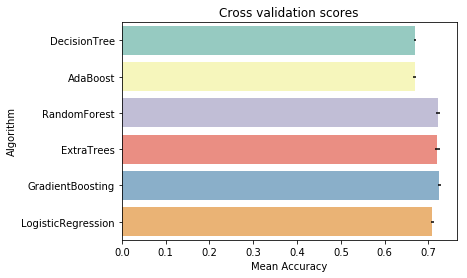

In [82]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=12))
    print(classifier)
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

#cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
#"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","LogisticRegression"]})


g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [83]:
cv_res

,Algorithm,CrossValMeans,CrossValerrors
0,DecisionTree,0.669482,0.002263
1,AdaBoost,0.668344,0.004127
2,RandomForest,0.722021,0.004311
3,ExtraTrees,0.720294,0.005090
4,GradientBoosting,0.724658,0.003295
5,LogisticRegression,0.709144,0.002987


#### 6.1.2 每个模型调节最好的超参数

对于AdaBoost、随机森林、梯度提升树进行超参数调参

In [84]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 12, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 560 out of 560 | elapsed: 15.7min finished


In [85]:
gsadaDTC.best_score_

0.6720923072804422

In [86]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 12, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 270 out of 270 | elapsed: 24.1min finished


0.7465967044587521

In [87]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 18.7min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed: 37.5min finished


0.7490195028578313

In [88]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 70.2min
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed: 164.7min finished


0.7496620129305153

#### 6.1.3 绘制学习曲线


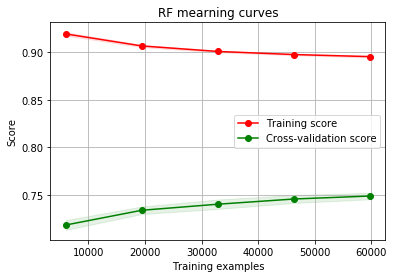

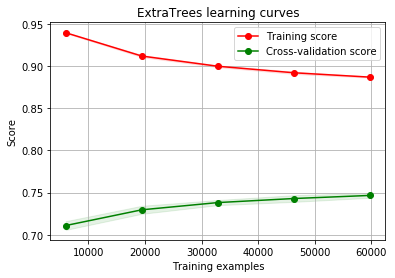

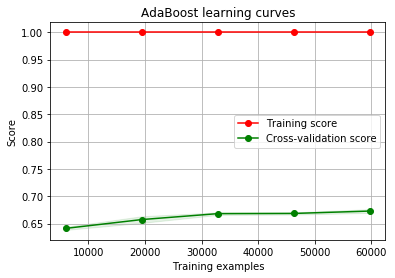

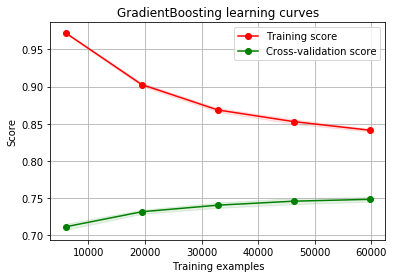

In [90]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

#### 6.1.4 树模型的特征重要性

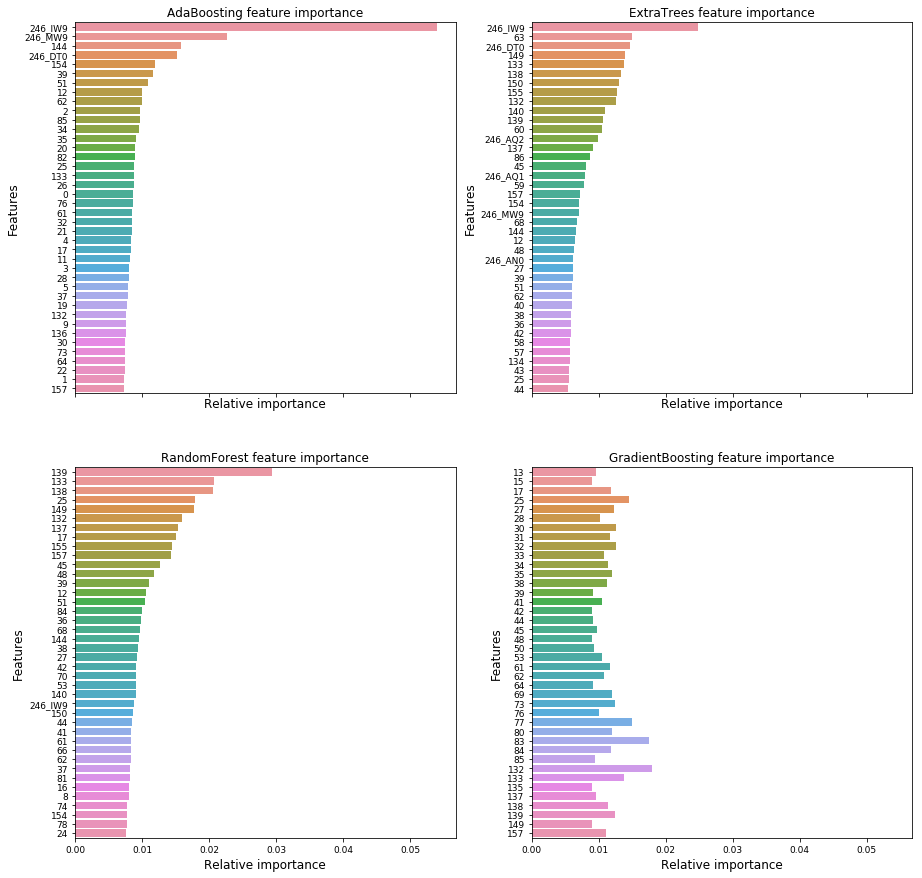

In [91]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

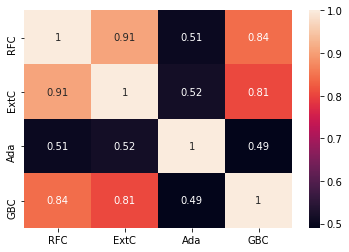

In [93]:
test_Survived_RFC = pd.Series(RFC_best.predict(test_set), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test_set), name="ExtC")
test_Survived_AdaC = pd.Series(ada_best.predict(test_set), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test_set), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

### 6.2 模型融合

In [94]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 预测
#### 6.3.1 预测并且提交结果

In [98]:
test_Survived = pd.Series(votingC.predict(test_set), name="label")


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [106]:
pred_label =votingC.predict(test_set)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [107]:
len(pred_label)

19226

In [108]:
len(test.index)

19226

In [111]:
submission = pd.DataFrame({
        "Id": test.index+1,
        "label": pred_label
    })
submission.to_csv('submit.csv', index=False)
